# Scalar Vector Graphics (SVG) with GeoLIPI
This Python notebook demonstrates the use of the GeoLIPI package for performing various Scalable Vector Graphics (SVG) operations. 


In [1]:
import sys
sys.path.append('../')

import numpy as np
import sympy as sp
import torch as th
import matplotlib.pyplot as plt

from geolipi.torch_compute import Sketcher
from geolipi.torch_compute import recursive_evaluate
import geolipi.symbolic as gls

In [2]:
resolution = 512
sketcher_2d = Sketcher(device="cuda", resolution=resolution, n_dims=2)
device = "cuda"


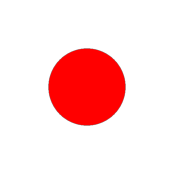

In [7]:
# Simple SVG
expression_1 = gls.ApplyColor2D(
        gls.Circle2D((0.5,)),
        (1.0, 0, 0, 1.0)
        )

output = recursive_evaluate(expression_1.tensor(), sketcher_2d, 
                               secondary_sketcher=None,
                               rectify_transform=True,
                               relaxed_occupancy=False,
                               relax_temperature=5)

image = output.reshape(resolution, resolution, 4).cpu().numpy()
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(image[:,:,:])

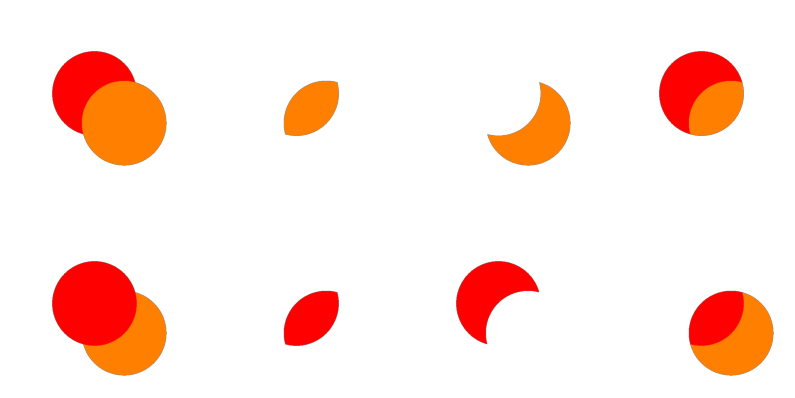

In [8]:
# show all the possible ways to combine two svgs

expression_11 = gls.ApplyColor2D(
    gls.Translate2D(
        gls.Circle2D((0.5,)),
    (0.35, 0.35)),
(1.0, 0.5, 0, 1.0))


functions = [gls.SourceOver, gls.SourceIn, gls.SourceOut, gls.SourceAtop, 
             gls.DestinationOver, gls.DestinationIn, gls.DestinationOut, gls.DestinationAtop] 

plt.figure(figsize=(10, 5))
for func in functions:
    mod_expr = func(expression_11, expression_1)
    output = recursive_evaluate(mod_expr.tensor(), sketcher_2d, 
                                secondary_sketcher=None,
                                rectify_transform=True,
                                relaxed_occupancy=False,
                                relax_temperature=5)

    image = output.reshape(resolution, resolution, 4).cpu().numpy()
    plt.subplot(2, 4, functions.index(func)+1)
    plt.axis('off')
    plt.imshow(image)

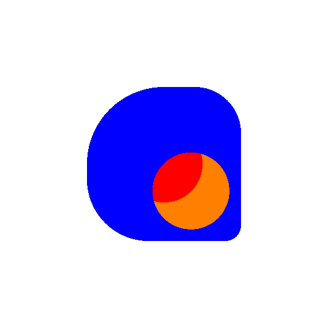

In [9]:
# Multiple Mix ops

expression_2 = gls.SourceAtop(expression_1, expression_11)
expression_2 = gls.Scale2D(expression_2, (0.5, 0.5))
expression_3 = gls.ApplyColor2D(
    gls.RoundedBox2D((0.5, 0.5), (0.1, 0.4, 0.3, 0.5)),
    (0, 0, 1., 1.))

expression_4 = gls.SourceOver(expression_2, expression_3)
output = recursive_evaluate(expression_4.tensor(), sketcher_2d, 
                               secondary_sketcher=None,
                               rectify_transform=False,
                               relaxed_occupancy=False,
                               relax_temperature=5)

image = output.reshape(resolution, resolution, 4).cpu().numpy()
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(image[:,:,:])

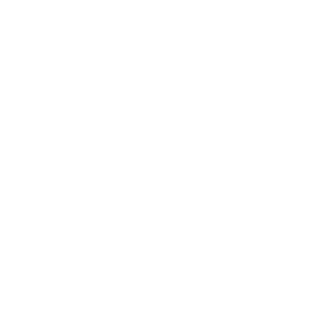

In [27]:
# Higher level sym functions
expression_5 = gls.Translate2D(
    gls.TranslationSymmetryX2D(
        gls.Scale2D(expression_4, (0.25, 0.25)), 
        (0.5,), 3),
    (-0.0, -0.0))
    
output = recursive_evaluate(expression_5.tensor(), sketcher_2d, 
                               secondary_sketcher=None,
                               rectify_transform=False,
                               relaxed_occupancy=False,
                               relax_temperature=5)

image = output.reshape(resolution, resolution, 4).cpu().numpy()
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(image[:,:,:])

In [17]:
# Create a complex SVG shape
# Each star is s Star with a star5 on a reg star
star_expression = gls.ApplyColor2D(
    gls.Star2D((0.7,),(0.25,)), sp.Symbol("burgundy"))


star_reg_expression = gls.ApplyColor2D(
    gls.RegularStar2D((0.5,), (12.,), (5.,)), sp.Symbol("lilac"))

circle_expr = gls.ApplyColor2D(
    gls.Circle2D((0.15,)), sp.Symbol("chartreuse"))

mix_expr = gls.SourceOver(circle_expr, gls.SourceAtop(star_expression, star_reg_expression))

(-0.5, 511.5, 511.5, -0.5)

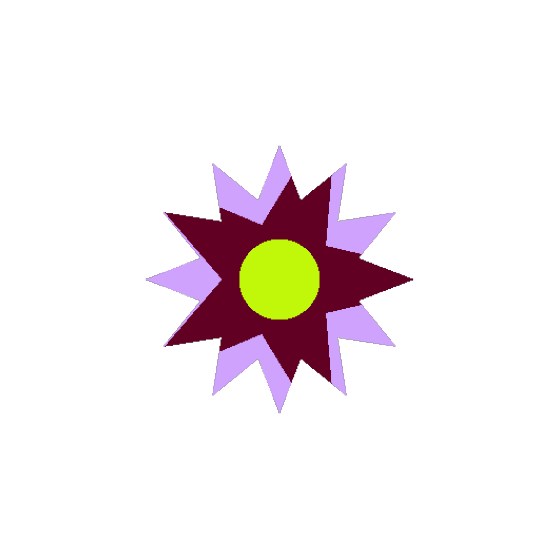

In [19]:

plt.figure(figsize=(7, 7))
output = recursive_evaluate(mix_expr.tensor(), sketcher_2d, 
                            secondary_sketcher=None,
                            rectify_transform=False,
                            relaxed_occupancy=False,
                            relax_temperature=5)

image = output.reshape(resolution, resolution, 4).cpu().numpy()
plt.imshow(image[:,:,:])
plt.axis('off')

In [20]:
# Stochastically scattered flowers on the grass
def scatter_flowers(mix_expr):
    flowers = []
    n_x = 4
    n_y = 4
    for i in range(n_x * n_y):
        scale_value = th.rand(1) * 0.1 + 0.25
        scale_value = th.cat([scale_value, scale_value])
        rotation_value = th.rand(1) * 2 * np.pi
        # based on nx and ny
        cur_nx = i % n_x
        cur_ny = i // n_x
        translation_value = 0.2 + th.tensor([cur_nx / n_x * 2 - 1, cur_ny / n_y * 2 - 1])
        translation_value = th.rand(2) * 0.2 + translation_value
        # print(scale_value, rotation_value, translation_value)
        transformed_flower = gls.Translate2D(gls.EulerRotate2D(gls.Scale2D(mix_expr, scale_value), rotation_value), translation_value)
        flowers.append(transformed_flower)

    flower_field = gls.SourceOverSequence(*flowers)
    return flower_field

def complete(mix_expr):
    flower_field = scatter_flowers(mix_expr)
    grass = gls.ApplyColor2D(
        gls.RoundedBox2D(th.tensor([0.95, 0.95]), th.tensor([0.3, 0.1, 0.5, 0.5])), sp.Symbol("green"))
    final = gls.DestinationOver(grass, flower_field)
    final= final.cuda()
    return final


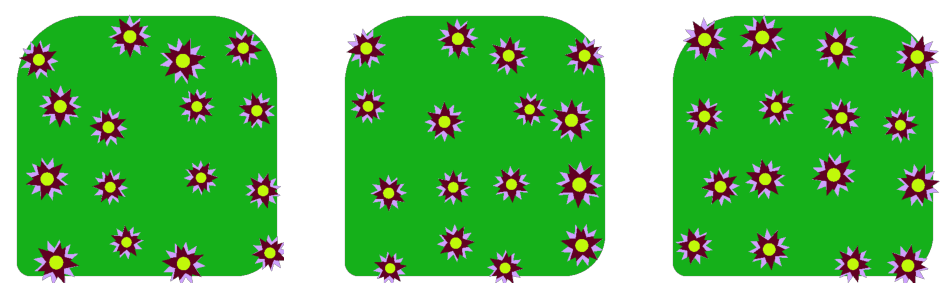

In [21]:

plt.figure(figsize=(12, 4))
for i in range(3):
    final = complete(mix_expr.tensor())
    output = recursive_evaluate(final, sketcher_2d, 
                                secondary_sketcher=None,
                                rectify_transform=False,
                                relaxed_occupancy=False,
                                relax_temperature=5)

    image = output.reshape(resolution, resolution, 4).cpu().numpy()
    plt.subplot(1, 3, i+1)
    plt.imshow(image[:,:,:])
    plt.axis('off')